In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

In [2]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "BTC/USD" 
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)
start = datetime(2021, 1, 1)
end = datetime.now().date() 

if not exists(SYM_HIST_FILE): # chacheing historical data  
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.index = data.index.date 
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
2021-01-01,BTC/USD,29255.71,29682.29,28707.56,29676.79,848.874030,29639.0,29316.444625
2021-01-02,BTC/USD,29678.34,34200.00,29555.99,33769.52,2144.592516,60152.0,31941.412694
2021-01-03,BTC/USD,33769.52,34812.93,32300.61,32908.02,1838.695433,58725.0,33505.269474
2021-01-04,BTC/USD,32907.36,33496.03,27900.00,30441.57,2711.189503,69226.0,31267.965121
2021-01-05,BTC/USD,30461.84,35851.42,29927.55,35063.00,1756.751333,61880.0,33151.367357


<Axes: >

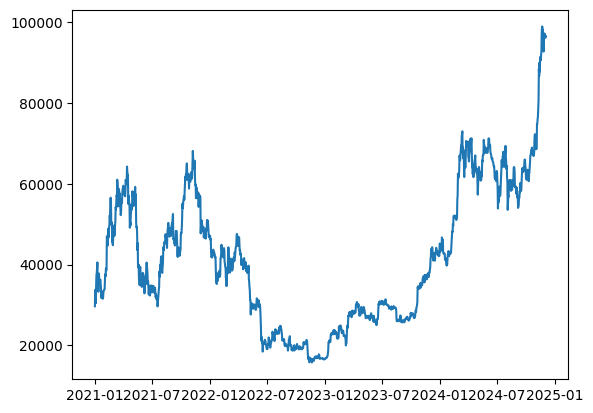

In [3]:
data["close"].plot()

In [4]:
# features 
data['returns'] = data['close'].pct_change()
data['MA50'] = data['close'].rolling(window=50).mean()
data['MA200'] = data['close'].rolling(window=200).mean()
data['volatility'] = data['returns'].rolling(window=20).std()

# lag 
data['prev_close'] = data['close'].shift(1)
data['prev_volume'] = data['volume'].shift(1)
data.dropna(inplace=True) 
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap,returns,MA50,MA200,volatility,prev_close,prev_volume
2021-07-19,BTC/USD,31759.93,31899.98,29509.14,29667.11,1337.030870,61933.0,30619.939419,-0.065470,34728.5194,44540.47975,0.026461,31745.48,719.037274
2021-07-20,BTC/USD,29666.06,30803.64,29295.61,30697.42,1234.390943,65743.0,29817.545488,0.034729,34607.3708,44545.58290,0.028061,29667.11,1337.030870
2021-07-21,BTC/USD,30698.54,32853.53,30559.50,32058.49,1685.076659,50437.0,31781.226696,0.044338,34515.2052,44537.02775,0.029235,30697.42,1234.390943
2021-07-22,BTC/USD,32062.68,32794.53,31727.19,32690.24,844.580569,25429.0,32243.873034,0.019706,34409.5450,44535.93885,0.029372,32058.49,1685.076659
2021-07-23,BTC/USD,32689.10,33855.04,31999.99,33708.83,891.558260,28135.0,32877.368316,0.031159,34332.1416,44552.27515,0.029262,32690.24,844.580569


In [5]:
class SeqPricePred(nn.Module):
    def __init__(self, input_size): 
        super(SeqPricePred,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
def eval(y_pred, y):
    trades = np.where(y_pred > y, 1,-1)
    strat_return = trades * np.log(y / np.roll(y, 1))
    print(f"Total return:  {np.sum(strat_return)}") 
    print(f"sharpe ratio: {np.mean(strat_return) / np.std(strat_return)}")

In [7]:
features = ['returns', 'MA50', 'MA200', 'volatility', 'prev_close', 'prev_volume']
X = data[features]
y = data["close"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_ped = rf_model.predict(X_test_scaled)

In [11]:
seq_model = SeqPricePred(input_size=len(features))
cirterion = nn.MSELoss()
optimzier = torch.optim.Adam(seq_model.parameters())

In [12]:
# Training 

X_torch = torch.FloatTensor(X_train_scaled)
y_torch = torch.FloatTensor(y_train.values)

for epoch in range(50):
    optimzier.zero_grad()
    outputs = seq_model(X_torch)
    loss = cirterion(outputs.squeeze(), y_torch)
    loss.backward()
    optimzier.step()

In [13]:
seq_y_pred = seq_model(torch.FloatTensor(X_test_scaled)).detach().numpy()
eval(seq_y_pred, y_test.values)

Total return:  -1.287303597052869e-13
sharpe ratio: -5.98922933341023e-17


In [14]:
eval(rf_ped, y_test.values)

Total return:  -2.4982897266023434
sharpe ratio: -0.29971532560295894
